In [7]:
from __future__ import absolute_import, division, print_function

import numpy as np
import torch
from torch import nn as nn
from torch.autograd import Variable
from torch.nn import Parameter

import pyro
import pyro.distributions as dist
import pyro.optim as optim
from pyro.distributions.transformed_distribution import TransformedDistribution
from pyro.infer import SVI
from pyro.util import ng_ones, ng_zeros
from tests import fakes
from tests.common import assert_equal
from tests.distributions.test_transformed_distribution import AffineExp

from matplotlib import pyplot
%matplotlib inline

In [8]:
pytestmark = pytest.mark.stage("integration", "integration_batch_2")
logger = logging.getLogger(__name__)

def param_mse(name, target):
    return torch.sum(torch.pow(target - pyro.param(name), 2.0)).data.cpu().numpy()[0]
def param_abs_error(name, target):
    return torch.sum(torch.abs(target - pyro.param(name))).data.cpu().numpy()[0]

In [38]:
class BernoulliBetaTests(object):
    def __init__(self):
        # bernoulli-beta model
        # beta prior hyperparameter
        self.alpha0 = Variable(torch.Tensor([1.0]))
        self.beta0 = Variable(torch.Tensor([1.0]))  # beta prior hyperparameter
        self.data = Variable(torch.Tensor([[0.0], [1.0], [1.0], [1.0]]))
        self.n_data = len(self.data)
        data_sum = self.data.sum(0)
        self.alpha_n = self.alpha0 + data_sum  # posterior alpha
        self.beta_n = self.beta0 - data_sum + Variable(torch.Tensor([self.n_data])) # posterior beta
        self.log_alpha_n = torch.log(self.alpha_n)
        self.log_beta_n = torch.log(self.beta_n)

    def test_elbo_reparameterized(self):
        return self.do_elbo_test(True, 3000, 0.95, 0.01)

    def test_elbo_nonreparameterized(self):
        return self.do_elbo_test(False, 3000, 0.95, 0.0007)

    def do_elbo_test(self, reparameterized, n_steps, beta1, lr):
        pyro.clear_param_store()
        beta = dist.beta if reparameterized else fakes.nonreparameterized_beta

        def model():
            p_latent = pyro.sample("p_latent", beta, self.alpha0, self.beta0)
            pyro.sample("obs", dist.bernoulli, torch.pow(torch.pow(p_latent, 2.0), 0.5),
                        obs=self.data)
            return p_latent

        def guide():
            alpha_q_log = pyro.param("alpha_q_log",
                                     Variable(self.log_alpha_n.data + 0.17, requires_grad=True))
            beta_q_log = pyro.param("beta_q_log",
                                    Variable(self.log_beta_n.data - 0.143, requires_grad=True))
            alpha_q, beta_q = torch.exp(alpha_q_log), torch.exp(beta_q_log)
            p_latent = pyro.sample("p_latent", beta, alpha_q, beta_q,
                                   baseline=dict(use_decaying_avg_baseline=True))
            return p_latent

        adam = optim.Adam({"lr": lr, "betas": (0.9, 0.99)})
        svi = SVI(model, guide, adam, loss="ELBO", trace_graph=True)

        log_alphas = []
        log_betas = []
        for k in range(n_steps):
            svi.step()
            alpha_error = param_abs_error("alpha_q_log", self.log_alpha_n)
            beta_error = param_abs_error("beta_q_log", self.log_beta_n)
            log_alphas.append([pyro.param('alpha_q_log').data[0]])
            log_betas.append([pyro.param('beta_q_log').data[0]])
            if k % 100 == 0:
                print("alpha_error, beta_error: %.4f, %.4f" % (alpha_error, beta_error))

        return log_alphas, log_betas

alpha_error, beta_error: 0.1650, 0.1380
alpha_error, beta_error: 0.0441, 0.2775
alpha_error, beta_error: 0.0760, 0.2435
alpha_error, beta_error: 0.1919, 0.2253
alpha_error, beta_error: 0.1327, 0.2815
alpha_error, beta_error: 0.1969, 0.2471
alpha_error, beta_error: 0.1211, 0.3480
alpha_error, beta_error: 0.2103, 0.3780
alpha_error, beta_error: 0.2491, 0.4486
alpha_error, beta_error: 0.3092, 0.4455
alpha_error, beta_error: 0.3237, 0.4580
alpha_error, beta_error: 0.3838, 0.4101
alpha_error, beta_error: 0.4355, 0.3728
alpha_error, beta_error: 0.4288, 0.3184
alpha_error, beta_error: 0.3644, 0.3138
alpha_error, beta_error: 0.3428, 0.2863
alpha_error, beta_error: 0.3737, 0.2603
alpha_error, beta_error: 0.3067, 0.3020
alpha_error, beta_error: 0.2593, 0.3161
alpha_error, beta_error: 0.2509, 0.3158
alpha_error, beta_error: 0.2990, 0.3151
alpha_error, beta_error: 0.2667, 0.3354
alpha_error, beta_error: 0.2935, 0.3541
alpha_error, beta_error: 0.2818, 0.3447
alpha_error, beta_error: 0.2548, 0.3953


Text(0,0.5,u'log_beta')

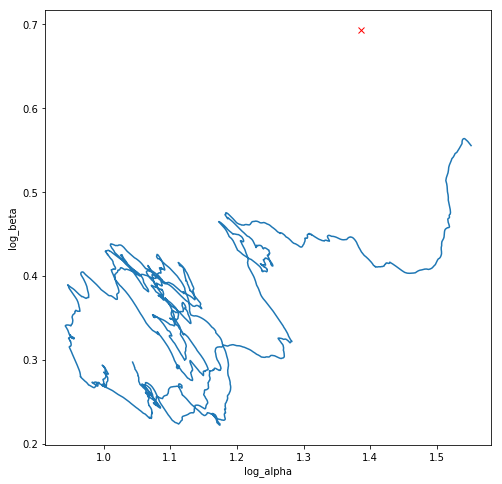

In [39]:
pyro.set_rng_seed(0)
test = BernoulliBetaTests()
log_alphas, log_betas = test.test_elbo_reparameterized()
pyplot.figure(figsize=(8,8)).patch.set_color('white')
pyplot.plot(log_alphas, log_betas)
pyplot.plot([test.log_alpha_n], [test.log_beta_n], 'rx')
pyplot.xlabel('log_alpha')
pyplot.ylabel('log_beta')